In [1]:
from dataset import *
from train import *


In [2]:
import os
import pandas as pd

import torch
import torch.optim as optim

import collections


import math

import collections

from sklearn.cluster import KMeans

In [3]:
# Set parameters
EuroSat_Type = 'ALL'    
target_country = 'France'

lr = 0.01               # learn_rate
milestones = [50,75,90] # multistep scheduler
epochs = 100            # no of epochs

output_path = "./" + target_country

## Download data

In [4]:
# raw data
if EuroSat_Type == 'RGB':
  data_folder = '/content/sample_data/'
  #root = os.path.join(data_folder, '2750/')
  root = '2750/'
  download_ON = os.path.exists(root)

  if not download_ON:
    # This can be long...
    #os.chdir(data_folder)
    os.system('wget http://madm.dfki.de/files/sentinel/EuroSAT.zip') #Just RGB Bands
    !unzip EuroSAT.zip
    download_ON = True
elif EuroSat_Type == 'ALL':
    root = 'ds/images/remote_sensing/otherDatasets/sentinel_2/tif/'
    download_ON = os.path.exists(root)
    if not download_ON:
      os.system('wget http://madm.dfki.de/files/sentinel/EuroSATallBands.zip') #All bands
      !unzip EuroSATallBands.zip
      download_ON = True
    
data = torchvision.datasets.DatasetFolder(root=root,loader = iloader, transform=None, extensions = 'tif')

In [5]:
# Metadata
geo_df = pd.read_csv("metadata.csv")
geo_dict = geo_df.to_dict()
countries = list(set(geo_dict["country"].values()))

### Find location for countries

In [6]:
country_location = dict.fromkeys(["country", "count", "latitude", "longitude"], [])
frequencies = collections.Counter(geo_df["country"])

In [7]:
# for all countries, find their locations
for c in countries:
    if c == c:# not nan
        if find_geo(c) != None:
            country_location["country"] = country_location["country"] + [c]
            loc = find_geo(c)
            country_location["latitude"] = country_location["latitude"] + [loc.latitude]
            country_location["longitude"] = country_location["longitude"] + [loc.longitude]
            country_location["count"] = country_location["count"] + [frequencies[c]]

In [8]:
country_location_df = pd.DataFrame.from_dict(country_location)
country_location_df

,country,count,latitude,longitude
0,Polska,1271,52.215933,19.134422
1,Schweiz/Suisse/Svizzera/Svizra,62,46.798562,8.231974
2,España,2304,39.326068,-4.837979
3,Nederland,1075,52.243498,5.634323
4,Deutschland,4415,51.163818,10.447831
5,Danmark,461,55.670249,10.333328
6,Suomi / Finland,430,63.246778,25.920916
7,Eesti,82,58.752378,25.331908
8,Österreich,1174,47.593970,14.124560
9,Slovensko,414,48.741152,19.452865


### clustering

In [9]:
kmeans = KMeans(n_clusters= 5, n_init=10, random_state=0, max_iter=1000)
X = country_location_df.loc[:, ["longitude", "latitude"]]
weights = country_location["count"]

In [10]:
kmeans.fit(X, sample_weight = weights)

KMeans(max_iter=1000, n_clusters=5, random_state=0)

In [12]:
country_location_df["cluster"] = kmeans.predict(X, sample_weight = weights)
clusters = dict.fromkeys(list(range(5)), 0)
for _, r in country_location_df.iterrows():
    clusters[r["cluster"]] += r["count"]
clusters

In [15]:
import matplotlib.pyplot as plt

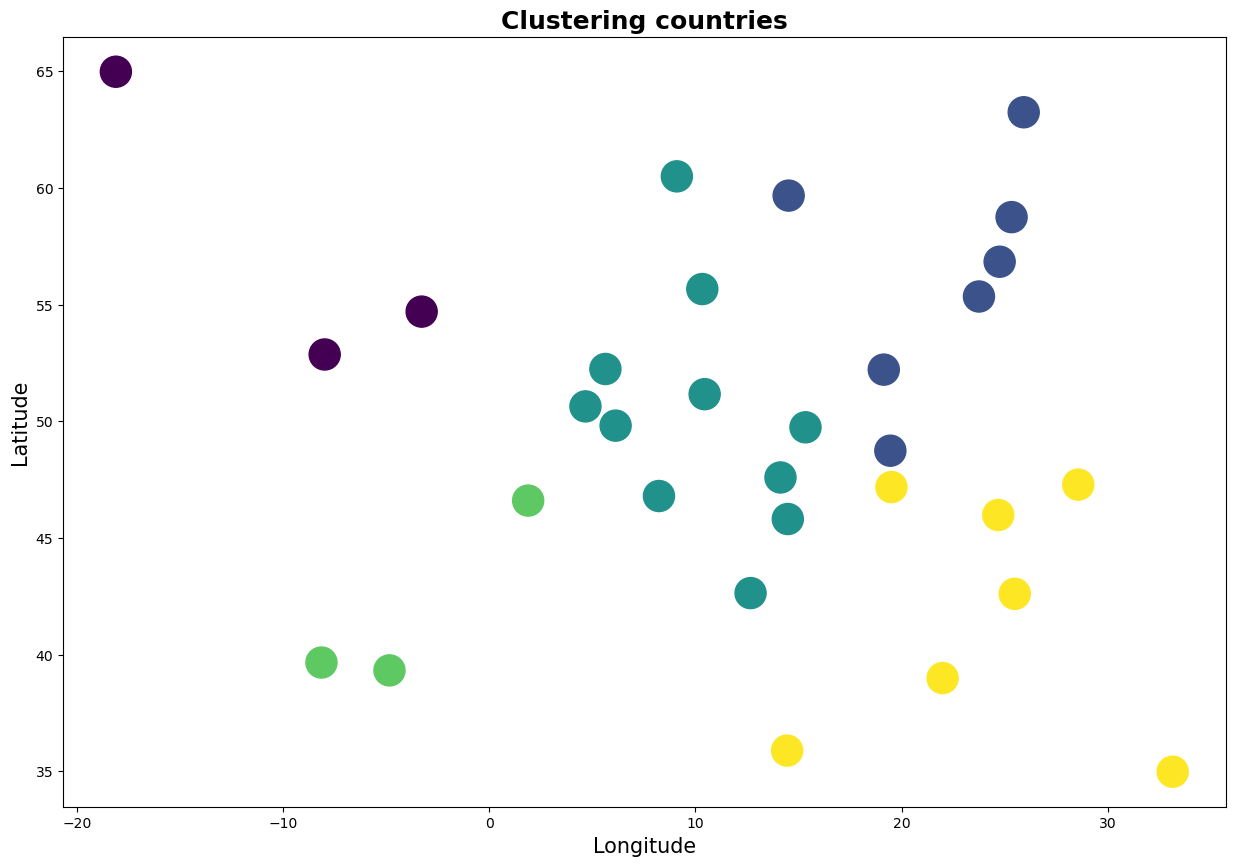

In [16]:
plt.style.use('default')
x = np.array(country_location_df['longitude'])
y = np.array(country_location_df['latitude'])
plt.figure(figsize = (15, 10))
plt.scatter(x, y, s = 500, #cmap='viridis',
            c = country_location_df["cluster"],
            label = 'Spend in Organic Products')
plt.title('Clustering countries', fontsize = 18, fontweight = 'bold')
plt.xlabel('Longitude', fontsize = 15)
plt.ylabel('Latitude', fontsize = 15)

centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=500, alpha=0.5);

In [21]:
pd.merge(geo_df, country_location_df.loc[:, ["country", "cluster"]], on='country', how='outer').to_csv("metadata_clustered.csv", index = False)
# globus link:
# https://g-5b2b0e.dtn.globus.wisc.edu/source_selection/eurosat/metadata_clustered.csv